In [1]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/Colab Notebooks/data

/content/drive/My Drive/Colab Notebooks/data


In [0]:
from __future__ import print_function
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import activations
from tensorflow.keras import utils
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        routings = 1
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [0]:
import numpy as np
import pandas as pd

In [0]:
df = pd.read_csv('dataframe2doubled50.csv')
texts = df.reviewText.astype(str)
target = df.overall

In [7]:
df.reviewText[60]

'It is a bit on the short side, but it works well to transmit data.'

In [8]:
target.value_counts()

1    100092
0     99908
Name: overall, dtype: int64

In [9]:
target.head()

0    1
1    0
2    0
3    1
4    1
Name: overall, dtype: int64

In [10]:
texts.head()

0    I was surprised to see a monster brand product...
1    I purchased 5 of these batteries at the end of...
2    I'm not happy with this product. I'm trying to...
3    Easy to setup.  I am using it with my PC and M...
4                 Perfect addition to my home  network
Name: reviewText, dtype: object

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
vocab_size = 30000
tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) # Generate sequences

In [13]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 84796 unique tokens.


In [14]:
inv_index = {v: k for k, v in tokenizer.word_index.items()}
for w in sequences[1]:
    x = inv_index.get(w)
    print(x,end = ' ')

i purchased 5 of these batteries at the end of august 2011 and by the end of sept 2011 5 months later none of them will hold a charge for more than 5 minutes without going dead purchase batteries from a reputable manufacturer and save yourself the hassle 

In [15]:
# Get the average length of a text
avg = sum( map(len, sequences) ) / len(sequences)
# Get the standard deviation of the sequence length
std = np.sqrt(sum( map(lambda x: (len(x) - avg)**2, sequences)) / len(sequences))
avg,std

(78.669555, 111.49545601100434)

In [0]:
data = pad_sequences(sequences, maxlen=100)

In [17]:
from tensorflow.keras.utils import to_categorical
labels = np.asarray(target)
print('Shape of data:', data.shape)
print('Shape of labels:', labels.shape)

Shape of data: (200000, 100)
Shape of labels: (200000,)


In [18]:
embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0] # The first value is the word, the rest are the values of the embedding
    embedding = np.asarray(values[1:], dtype='float32') # Load embedding
    embeddings_index[word] = embedding # Add embedding to our embedding dictionary
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [19]:
all_embs = np.stack(embeddings_index.values())
emb_mean = all_embs.mean() # Calculate mean
emb_std = all_embs.std() # Calculate standard deviation
emb_mean, emb_std

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(-0.0039050116, 0.38177028)

In [0]:
embedding_dim = 300

In [0]:
word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index)) 
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocab_size: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, Bidirectional, GRU, LSTM

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_accuracy', patience = 2)
callback = [early_stopping]

In [0]:
import warnings
warnings.simplefilter('ignore')

In [0]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['negative','positive']

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(2),
           yticks=np.arange(2),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    return ax

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.25, random_state=100)

In [30]:
inputz = Input(shape=(100,))
embedz = Embedding(vocab_size, 
                        embedding_dim, 
                        input_length=100, 
                        weights = [embedding_matrix], 
                        trainable = False)(inputz)
embedz1 = SpatialDropout1D(0.1)(embedz)
gruz = LSTM(64, return_sequences=True)(embedz)
capsulez = Capsule(num_capsule=8, dim_capsule=32, routings=3, share_weights=True)(gruz)
# print(capsulez.shape)
capsulez = Flatten()(capsulez)
# print(capsulez.shape)
# print(gruz.shape)
capsulez = Dropout(0.1)(capsulez)
outputz = Dense(64, activation='relu')(capsulez)

outputz = Dense(1, activation='sigmoid')(capsulez)
modelz = Model(inputs=inputz, outputs=outputz)
modelz.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

historyz = modelz.fit(X_train,Y_train,epochs=10, validation_data = [X_test, Y_test], callbacks=callback);

Train on 150000 samples, validate on 50000 samples
Epoch 1/10
150000/150000 [==============================] - 637s 4ms/sample - loss: 0.2770 - accuracy: 0.8819 - val_loss: 0.2590 - val_accuracy: 0.8935
Epoch 2/10
150000/150000 [==============================] - 634s 4ms/sample - loss: 0.1885 - accuracy: 0.9266 - val_loss: 0.1947 - val_accuracy: 0.9232
Epoch 3/10
150000/150000 [==============================] - 636s 4ms/sample - loss: 0.1516 - accuracy: 0.9425 - val_loss: 0.1718 - val_accuracy: 0.9362
Epoch 4/10
150000/150000 [==============================] - 641s 4ms/sample - loss: 0.1246 - accuracy: 0.9541 - val_loss: 0.1647 - val_accuracy: 0.9375
Epoch 5/10
150000/150000 [==============================] - 643s 4ms/sample - loss: 0.1017 - accuracy: 0.9640 - val_loss: 0.1693 - val_accuracy: 0.9423
Epoch 6/10
150000/150000 [==============================] - 646s 4ms/sample - loss: 0.0843 - accuracy: 0.9708 - val_loss: 0.1719 - val_accuracy: 0.9440
Epoch 7/10
150000/150000 [===========

In [28]:
Y_pred = np.round(np.clip(modelz.predict(X_test, verbose=1), 0, 1)).astype(int)

50000/50000 [==============================] - 48s 964us/sample


              precision    recall  f1-score   support

           0       0.94      0.95      0.95     25060
           1       0.95      0.94      0.95     24940

    accuracy                           0.95     50000
   macro avg       0.95      0.95      0.95     50000
weighted avg       0.95      0.95      0.95     50000



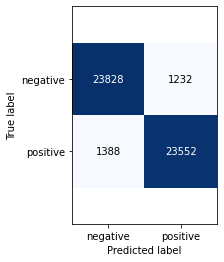

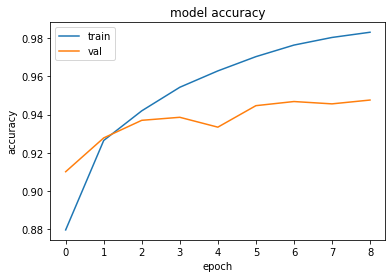

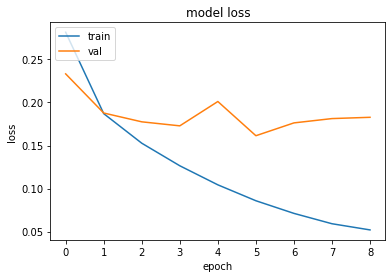

In [29]:
print(classification_report(Y_test, Y_pred))

plot_confusion_matrix(Y_test, Y_pred)
plt.show()

plt.plot(historyz.history['accuracy'])
plt.plot(historyz.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(historyz.history['loss'])
plt.plot(historyz.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()